Bradford Silent Substitution
============================

In [7]:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import basinhopping, Bounds
from scipy.interpolate import interp1d

from pysilsub.problem import SilentSubstitutionProblem
from pysilsub.plotting import stim_plot
from pysilsub.CIE import get_CIES026

sns.set_context('notebook')
sns.set_style('ticks')

Load data from sphere
---------------------
These are the data collected by Riccardo on 26/10/2021

In [3]:
spds = pd.read_csv('../../BradfordPupillometry/data/new/external_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# List of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']
spds = spds.sort_index()
spds

380           381           382           383  \
Primary Setting                                                           
0       0        1.130000e-08  1.380000e-08  2.950000e-09  0.000000e+00   
        65       8.380000e-07  1.030000e-06  1.060000e-06  7.220000e-07   
        130      1.040000e-07  1.650000e-07  1.630000e-07  9.320000e-07   
        195      2.010000e-06  3.720000e-06  5.080000e-06  5.090000e-06   
        260      7.880000e-06  7.150000e-06  9.470000e-06  7.480000e-06   
...                       ...           ...           ...           ...   
9       3835     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        3900     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        3965     4.680000e-06  5.740000e-06  1.220000e-06  0.000000e+00   
        4030     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        4095     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                          384       385           386           387  \
Primary Setting                                                       
0       0        0.000000e+00  0.000000  8.260000e-09  2.690000e-08   
        65       3.670000e-07  0.000001  1.420000e-06  8.830000e-07   
        130      1.810000e-06  0.000001  7.400000e-07  1.070000e-06   
        195      4.440000e-06  0.000002  8.720000e-07  2.830000e-06   
        260      4.410000e-06  0.000006  6.440000e-06  5.980000e-06   
...                       ...       ...           ...           ...   
9       3835     0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
        3900     0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
        3965     0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
        4030     0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
        4095     0.000000e+00  0.000000  0.000000e+00  0.000000e+00   

                          388           389  ...           771           772  \
Primary Setting                              ...                               
0       0        1.590000e-08  0.000000e+00  ...  1.790000e-06  1.580000e-06   
        65       6.230000e-07  5.090000e-07  ...  2.330000e-06  2.120000e-06   
        130      2.290000e-06  3.790000e-06  ...  1.550000e-06  2.350000e-06   
        195      3.750000e-06  4.420000e-06  ...  1.270000e-06  4.490000e-06   
        260      9.800000e-06  1.360000e-05  ...  6.160000e-06  3.080000e-06   
...                       ...           ...  ...           ...           ...   
9       3835     2.880000e-06  5.450000e-06  ...  0.000000e+00  0.000000e+00   
        3900     0.000000e+00  0.000000e+00  ...  3.540000e-06  9.460000e-07   
        3965     2.950000e-06  5.590000e-06  ...  5.180000e-07  3.260000e-06   
        4030     0.000000e+00  0.000000e+00  ...  4.790000e-05  1.280000e-05   
        4095     0.000000e+00  4.850000e-07  ...  5.250000e-07  3.300000e-06   

                      773           774       775       776           777  \
Primary Setting                                                             
0       0        0.000001  1.360000e-06  0.000002  0.000001  9.370000e-07   
        65       0.000002  2.020000e-06  0.000002  0.000002  1.250000e-06   
        130      0.000002  8.770000e-07  0.000002  0.000003  1.590000e-06   
        195      0.000004  2.610000e-06  0.000004  0.000004  3.600000e-06   
        260      0.000002  2.210000e-06  0.000005  0.000005  1.810000e-06   
...                   ...           ...       ...       ...           ...   
9       3835     0.000026  6.520000e-05  0.000093  0.000074  1.120000e-05   
        3900     0.000000  0.000000e+00  0.000000  0.000008  2.450000e-05   
        3965     0.000003  0.000000e+00  0.000000  0.000000  0.000000e+00   
        4030     0.000012  2.870000e-05  0.000009  0.000001  4.250000e-06   
        4095     0.000003  0.000000e+00  0.000000  0.000000  0.000000e+00   

                          778       779       780  
Primary Setting                

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: Stimulation Device
Backgorund: None
Ignoring: ['R']
Silencing: ['I']
Isolating: ['S', 'M', 'L']
Target contrast: None
Bounds: [(0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7), (0.0, 0.7)]


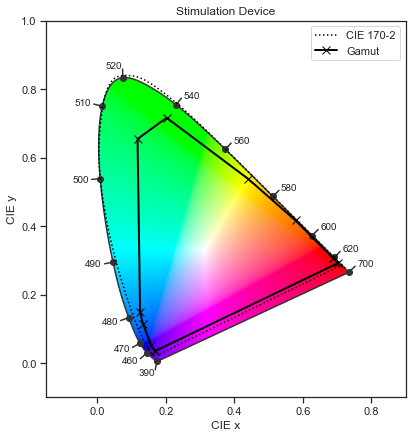

In [8]:
# custom bounds
# bounds = [(0,.7) for i in range(10)]

# Instantiate the class / define the problem
ss = SilentSubstitutionProblem(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1,
    ignore=['R'],
    silence=['I'], # Silence melanopsin
    isolate=['S', 'M', 'L'], # Isolate LMS
    background=None,
    bounds=[(0., .7) for bnds in range(10) ],
)

_ = ss.plot_gamut()

basinhopping step 0: f 0.918459


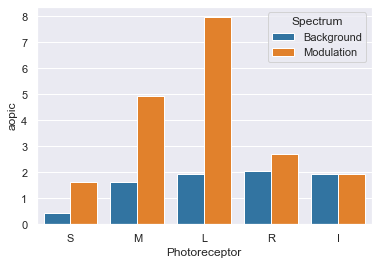

basinhopping step 1: f 0.965418 trial_f 0.965418 accepted 1  lowest_f 0.918459


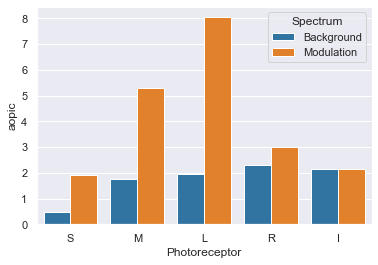

basinhopping step 2: f 0.965418 trial_f 4.73665 accepted 0  lowest_f 0.918459


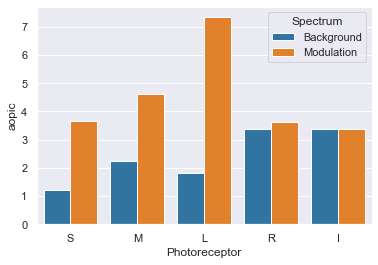

basinhopping step 3: f 0.958193 trial_f 0.958193 accepted 1  lowest_f 0.918459


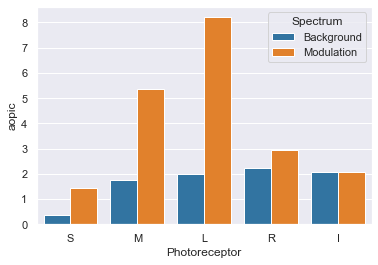

basinhopping step 4: f 0.599764 trial_f 0.599764 accepted 1  lowest_f 0.599764
found new global minimum on step 4 with function value 0.599764


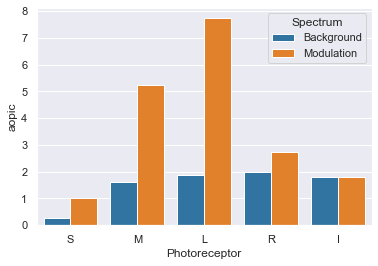

basinhopping step 5: f 0.599764 trial_f 2.07119 accepted 0  lowest_f 0.599764


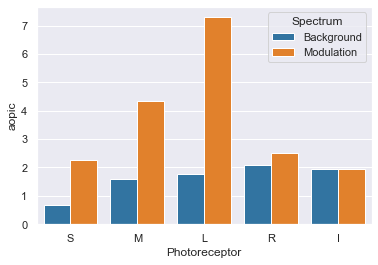

basinhopping step 6: f 0.797557 trial_f 0.797557 accepted 1  lowest_f 0.599764


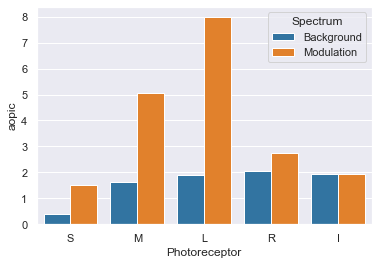

basinhopping step 7: f 0.797557 trial_f 2.73167 accepted 0  lowest_f 0.599764


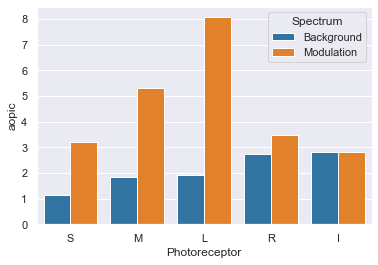

basinhopping step 8: f 0.564352 trial_f 0.564352 accepted 1  lowest_f 0.564352
found new global minimum on step 8 with function value 0.564352


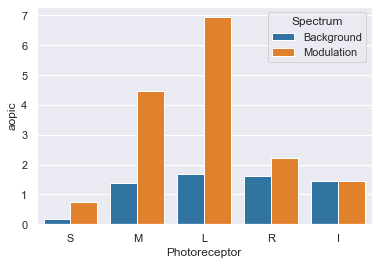

basinhopping step 9: f 0.564352 trial_f 1.61913 accepted 0  lowest_f 0.564352


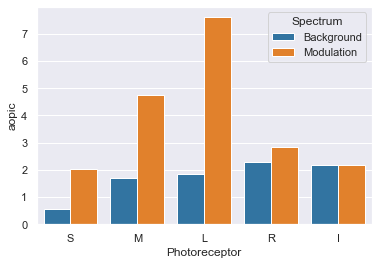

basinhopping step 10: f 0.328395 trial_f 0.328395 accepted 1  lowest_f 0.328395
found new global minimum on step 10 with function value 0.328395


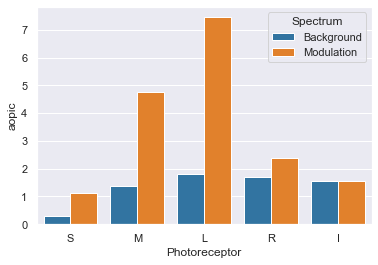

basinhopping step 11: f 3.07063e-07 trial_f 3.07063e-07 accepted 1  lowest_f 3.07063e-07
found new global minimum on step 11 with function value 3.07063e-07


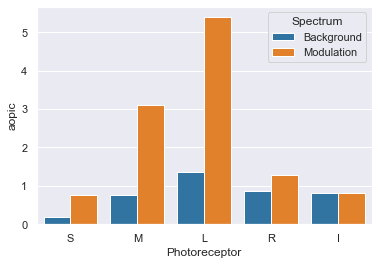

In [4]:
# Find a solution
result = ss.find_modulation_spectra(
    target_contrast=4.,
    tollerance=.01
)

<AxesSubplot:>

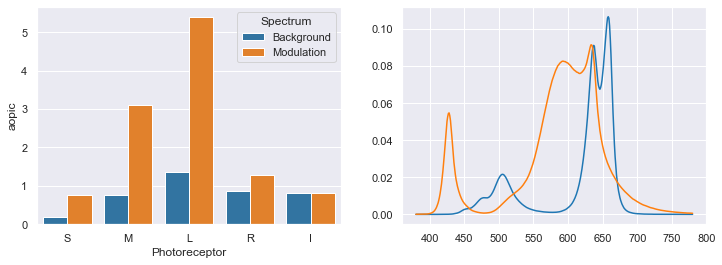

In [5]:
def plot_solution(background, modulation, ax=None):
    df = (
        pd.concat([background, modulation], axis=1)
        .T.melt(
            value_name='aopic',
            var_name='Photoreceptor',
            ignore_index=False)
        .reset_index()
        .rename(
            columns={'index': 'Spectrum'})
         )
    sns.barplot(data=df, x='Photoreceptor', y='aopic', hue='Spectrum', ax=ax)
    
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

bg_ao = ss.predict_multiprimary_aopic(result.x[0:10], name='Background')
mod_ao = ss.predict_multiprimary_aopic(result.x[10:20], name='Modulation')

bg_spd = ss.predict_multiprimary_spd(result.x[0:10], name='Background')
mod_spd = ss.predict_multiprimary_spd(result.x[10:20], name='Modulation')

plot_solution(bg_ao.T.squeeze(), mod_ao.T.squeeze(), ax=axs[0])

bg_spd.T.plot(ax=axs[1])
mod_spd.T.plot(ax=axs[1])

In [6]:
print(f'The background settings are {ss.weights_to_settings(result.x[0:10])}')
print(f'The modulation settings are {ss.weights_to_settings(result.x[10:20])}')

The background settings are [0, 0, 15, 213, 799, 0, 0, 42, 2653, 2383]
The modulation settings are [1525, 0, 0, 0, 6, 0, 618, 2857, 1493, 1]


The actual contrast is
----------------------

In [8]:
(mod_ao[['S','M','L']] / (bg_ao * 4)[['S','M','L']]) * 3


S    2.999703
M    3.000286
L    2.999945
dtype: float64